In [2]:
import os
import sys
sys.path.append("../") # go to parent dir
import glob
import time
import pathlib
import logging
import numpy as np
from scipy.sparse import linalg as spla
#from dedalus.tools.config import config
#from simple_sphere import SimpleSphere, TensorField, TensorSystem
#import equations
import matplotlib.pyplot as plt
%matplotlib inline
#import cartopy.crs as ccrs
#from dedalus.extras import plot_tools
import logging
from mpl_toolkits import mplot3d
logger = logging.getLogger(__name__) 
from matplotlib.animation import FFMpegWriter
from matplotlib.patches import Rectangle, Wedge
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

STRNAME = "sphere118"
#add path to data folder
input_folder = "/Volumes/ExtDrive/data"
output_folder = "/Users/Rohit/Documents/research/active_matter_spheres/scripts/garbage"
first_frame = 1
last_frame = len(glob.glob1('%s/%s/' %(input_folder, STRNAME),"*.npz"))
#last_frame = 3000
dpi = 256
Omega = 500
if STRNAME == "sphere118":
    Lmid = 8
elif STRNAME == "sphere110":
    Lmid = 4
else: 
    Lmid = 2

# Setup output folder
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

print('Total time stamps = %i' %(last_frame-first_frame))


Total time stamps = 4999


In [3]:
t_arr = np.zeros(last_frame)

with np.load('%s/%s/output_%i.npz' %(input_folder, STRNAME, 1)) as file:
    phi = file['phi']
    theta = file['theta']

om = np.zeros((last_frame, phi.shape[0], theta.shape[0]))
#vph = np.zeros_like(om)
    
for ind in range(first_frame, last_frame + 1, 1):
    if ind%100==0: print(ind)
    with np.load('%s/%s/output_%i.npz' %(input_folder, STRNAME, ind)) as file:
        #vph[ind-1, :, :] = file['v_ph']
        om[ind-1, :, :] = file['om']
        t_arr[ind-1] = file['t'][0]
        
om_max = np.max(om)
#vph_max = np.max(vph)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000


In [4]:
#get gammas from Lmid and kappa setting R=1 and tau=1
def get_gammas(Lmid, kappa):
    
    a = 0.25*(Lmid**2*kappa**2 - 0.5*(2*np.pi*Lmid+1)**2)**2 + 17*17/16 - (34/16)*(2*np.pi*Lmid+1)**2
    b = (17/4 - 0.25*(2*np.pi*Lmid+1)**2)**2
    c = 1/(17/4 - 0.25*(2*np.pi*Lmid + 1)**2 - 2)
    gamma0 = a*c/(a-b)
    gamma2 = -2*np.sqrt(b)*c/(a-b)
    gamma4 = c/(a-b)
    
    return [gamma0, gamma2, gamma4]

#define function that returns the neutral ell's for a given R/Lambda and kappa
def get_l(Lmid, kappa):
    
    gamma0, gamma2, gamma4 = get_gammas(Lmid, kappa)
    delta_p = (0.5/gamma4)*(-gamma2+np.sqrt(gamma2**2-4*gamma0*gamma4))
    delta_m = (0.5/gamma4)*(-gamma2-np.sqrt(gamma2**2-4*gamma0*gamma4))
    
    l_p = 0.5*(-1+np.sqrt(17+4*delta_p))
    l_m = 0.5*(-1+np.sqrt(17+4*delta_m))
        
    return l_m, l_p

def get_k(γ0, γ2, γ4):
    k_m = np.sqrt((-γ2 - np.sqrt(γ2**2 - 4*γ0*γ4))/(2*γ4))
    k_p = np.sqrt((-γ2 + np.sqrt(γ2**2 - 4*γ0*γ4))/(2*γ4))
    
    return k_m, k_p

def get_kmax(γ0, γ2, γ4):
    k_max = np.sqrt(-γ2/(2*γ4))
    
    return k_max
    


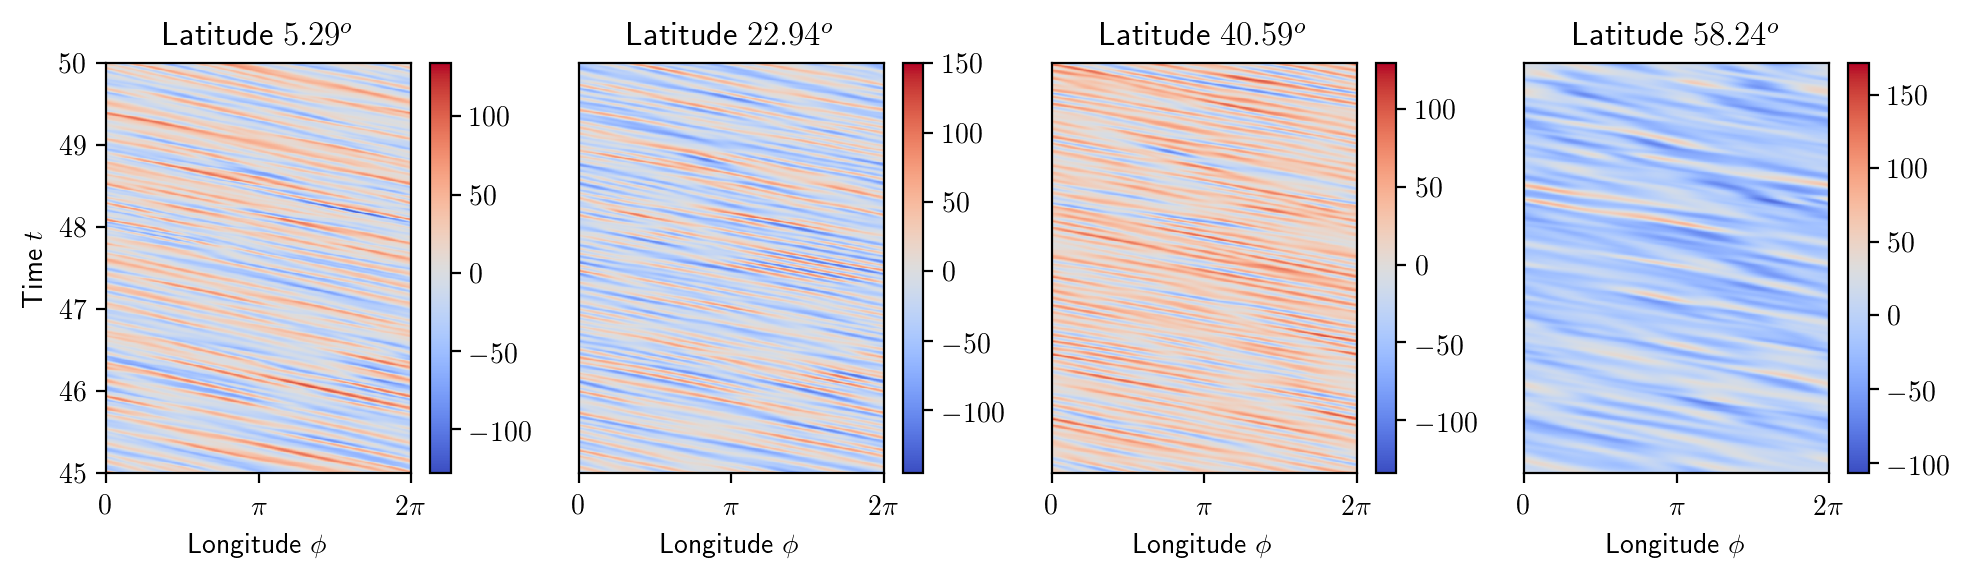

In [10]:
th_inds = np.arange(135, 220, 25, dtype=int)
theta_ = np.linspace(np.pi, 0, len(theta))

plt.figure(figsize=(10, 3), dpi=200)
plt.rc('text', usetex=True)

count = 1
for i in th_inds:
    plt.subplot(1, len(th_inds), count)
    plt.pcolormesh(phi, t_arr, om[:,:,i]-np.mean(om[:,:,i]), cmap='coolwarm', rasterized=True)
    plt.colorbar()
    plt.ylim([45,50])
    if count != 1: plt.yticks([], [])
    else: plt.ylabel('Time $t$', usetex=True)
    plt.title(r'Latitude $%0.2f^{o}$' %((np.pi/2-theta_[i])*180/np.pi))
    plt.xlabel(r'Longitude $\phi$', usetex=True)
    plt.xticks([0, np.pi, 2*np.pi], labels=[r'$0$', r'$\pi$', r'$2 \pi$'])

    count += 1

plt.tight_layout()

#plt.savefig('../plots/rossby_colorplot.png')


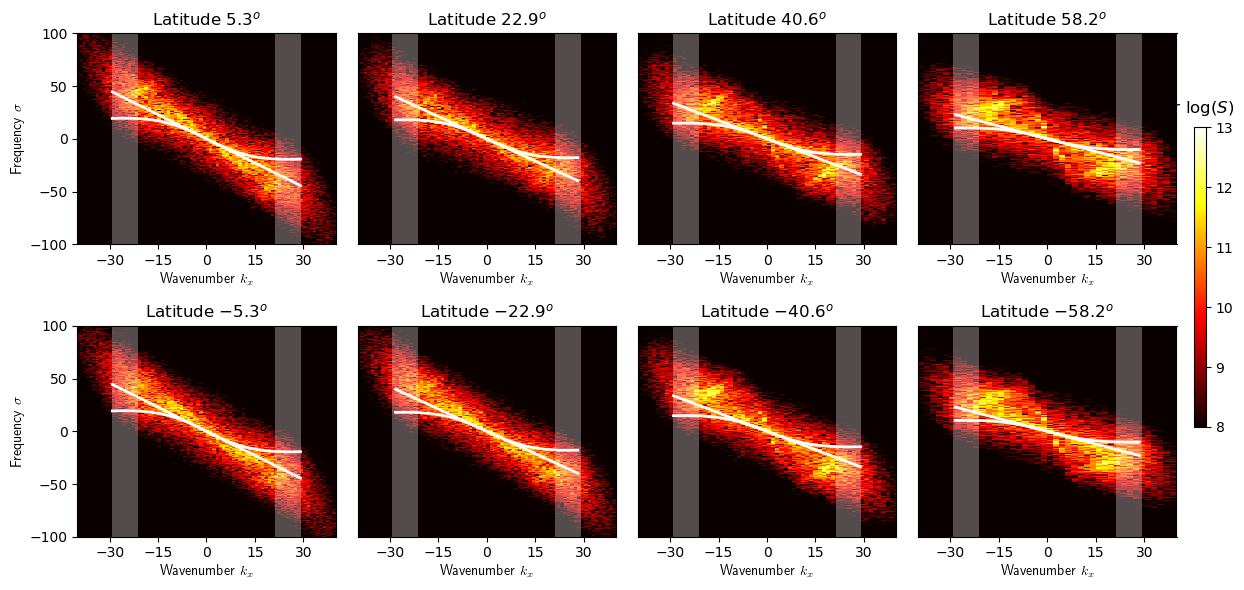

In [26]:
th_inds = np.hstack([np.arange(135, 220, 25, dtype=int), np.arange(120, 30, -25)])
#just make the grid symmetric
theta_ = np.linspace(np.pi, 0, len(theta))

##### Plot FFT ######
fig = plt.figure(figsize=(12, 6), dpi=100)

time_inds = np.arange(1000, 5000, 1)

#set the vertical wavenumber
k_m, k_p = get_k(*get_gammas(Lmid,1))
k_max = get_kmax(*get_gammas(Lmid,1))

window = np.hamming(len(time_inds)).reshape(len(time_inds),1)

count = 1
for i in th_inds:
    
    sig_eq = om[:, :, i]
    
    sig_fft = np.fft.fft2(sig_eq[time_inds, :]*window)
    sig_fft = np.fft.fftshift(sig_fft)
    dphi = phi[2] - phi[1]
    dt = t_arr[2] - t_arr[1]

    phi_freq = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(phi), d=dphi))
    #time freq is taken to be negative to be consistent with the waves definition
    time_freq = -2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(t_arr[time_inds]), d=dt))
    
    kx = phi_freq/np.sin(theta_[i])

    
    plt.subplot(2, len(th_inds)/2, count)
    img = plt.pcolormesh(kx, time_freq, np.log10(np.abs(sig_fft)**2), cmap='hot',vmin=8, vmax=13,rasterized=True)
    if count != 1 and count !=len(th_inds)/2+1: plt.yticks([], [])
    else: plt.ylabel(r'Frequency $\sigma$', usetex=True)
    plt.title(r'Latitude $%0.1f^{o}$' %((np.pi/2-theta_[i])*180/np.pi))
    plt.xlabel(r'Wavenumber $k_x$', usetex=True)
    
    kx_plot = kx.copy()
    kx_plot[kx < -k_p] = np.nan
    kx_plot[kx > k_p] = np.nan
    plt.plot(kx_plot, -2*Omega*kx_plot*np.sin(theta_[i])/(k_max**2), 'w', linewidth=2)
    plt.xticks([-30, -15, 0, 15, 30])
    #branch with ky=k_max
    plt.plot(kx_plot, -2*Omega*kx_plot*np.sin(theta_[i])/(kx_plot**2 + k_max**2), 'w', linewidth=2)
    
    rect = Rectangle((-k_p, -150), k_p-k_m, 300, facecolor='white', alpha=0.3)
    plt.gca().add_patch(rect)
    rect = Rectangle((k_m, -150), k_p-k_m, 300, facecolor='white', alpha=0.3)
    plt.gca().add_patch(rect)

    plt.ylim([-100, 100])
    plt.xlim([-40, 40])
    
    if count == len(th_inds):
        fig.subplots_adjust(right=0.9)
        cbaxes = fig.add_axes([0.999, 0.28, 0.01, 0.5]) 
        cb = fig.colorbar(img, cax = cbaxes)
        cb.ax.set_title(r'rr $\log(S)$', pad=10)
    
    count += 1

fig.tight_layout()
#plt.savefig('../plots/%s_disp.pdf' %(STRNAME), bbox_inches='tight')


# Figure 4 of the paper

In [1]:
import matplotlib as mpl
fm = mpl.font_manager
fm.get_cachedir()

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

th_inds_north = np.arange(135, 220, 25, dtype=int)
th_inds_south = np.arange(120, 30, -25)

th_inds = np.hstack([th_inds_north, th_inds_south])
#just make the grid symmetric
theta_ = np.linspace(np.pi, 0, len(theta))


time_inds = np.arange(1000, 5000, 1)

#set the vertical wavenumbervmin=-75, vmax=75
k_m, k_p = get_k(*get_gammas(Lmid,1))
k_max = get_kmax(*get_gammas(Lmid,1))

window = np.hamming(len(time_inds)).reshape(len(time_inds),1)

fig = plt.figure(figsize=(12, 7), dpi=200)

count = 1
for i in th_inds_north:
    plt.subplot(3, len(th_inds)/2, count)
    img1 = plt.pcolormesh(phi, t_arr, om[:,:,i], cmap='RdBu_r', rasterized=True, vmin=-100, vmax=100)
    #plt.colorbar()
    plt.ylim([45,50])
    if count != 1: plt.yticks([], [])
    else: plt.ylabel(r'Time $t$', usetex=True)
    plt.title(r'Latitude $%0.1f^{o}$' %((np.pi/2-theta_[i])*180/np.pi))
    plt.xlabel(r'Longitude $\phi$', usetex=True)
    plt.xticks([0, np.pi, 2*np.pi], labels=[r'$0$', r'$\pi$', r'$2 \pi$'])

    count += 1

count = 1
for i in th_inds:
    
    sig_eq = om[:, :, i]
    
    sig_fft = np.fft.fft2(sig_eq[time_inds, :]*window)
    sig_fft = np.fft.fftshift(sig_fft)
    dphi = phi[2] - phi[1]
    dt = t_arr[2] - t_arr[1]

    phi_freq = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(phi), d=dphi))
    #time freq is taken to be negative to be consistent with the waves definition
    time_freq = -2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(t_arr[time_inds]), d=dt))
    
    kx = phi_freq/np.sin(theta_[i])

    
    plt.subplot(3, len(th_inds)/2, 4+count)
    img2 = plt.pcolormesh(kx, time_freq, np.log10(np.abs(sig_fft)**2), cmap='hot', vmin=8, vmax=15, rasterized=True)
    if count != 1 and count !=len(th_inds)/2+1: plt.yticks([], [])
    else: plt.ylabel(r'Frequency $\sigma$', usetex=True)
    plt.title(r'Latitude $%0.1f^{o}$' %((np.pi/2-theta_[i])*180/np.pi))
    plt.xlabel(r'Wavenumber $k_x$', usetex=True)
    
    kx_plot = kx.copy()
    kx_plot[kx < -k_p] = np.nan
    kx_plot[kx > k_p] = np.nan
    plt.plot(kx_plot, -2*Omega*kx_plot*np.sin(theta_[i])/(k_max**2), 'w', linewidth=2, rasterized=True)
    plt.xticks([-30, -15, 0, 15, 30])
    
    rect = Rectangle((-k_p, -150), k_p-k_m, 300, facecolor='white', alpha=0.3, rasterized=True)
    plt.gca().add_patch(rect)
    rect = Rectangle((k_m, -150), k_p-k_m, 300, facecolor='white', alpha=0.3, rasterized=True)
    plt.gca().add_patch(rect)

    plt.ylim([-100, 100])
    plt.xlim([-40, 40])
    
    if count == len(th_inds):
        fig.subplots_adjust(right=0.9)
        cbaxes1 = fig.add_axes([0.999, 0.75, 0.01, 0.16])
        cbaxes2 = fig.add_axes([0.999, 0.16, 0.01, 0.4]) 

        cb1 = fig.colorbar(img1, cax = cbaxes1)
        cb2 = fig.colorbar(img2, cax = cbaxes2)

        cb1.ax.set_title(r'$\zeta$', pad=10)
        cb2.ax.set_title(r'$\log(S)$', pad=10)
    
    count += 1

fig.tight_layout()
plt.savefig('../plots/figure4_%s.pdf' %(STRNAME), bbox_inches='tight', dpi=300)


AttributeError: module 'matplotlib' has no attribute 'font_manager'

### Find the ridge

Slope is -2.72


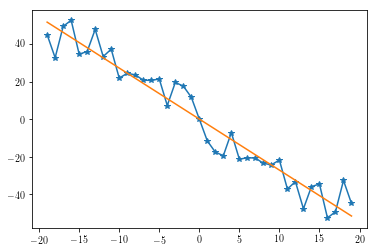

In [14]:
m_max = 20

#find the ridge 
th_ind = 230
sig_eq = om[:, :, th_ind]
sig_fft = np.fft.fft2(sig_eq[time_inds, :]*window)
sig_fft = np.fft.fftshift(sig_fft)
dphi = phi[2] - phi[1]
dt = t_arr[2] - t_arr[1]
phi_freq = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(phi), d=dphi))
time_freq = -2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(t_arr[time_inds]), d=dt))
    
mag = np.abs(sig_fft)
ridge = np.zeros(phi_freq.shape[0])

for i, m in enumerate(phi_freq):
    if np.abs(m)<m_max:
        max_ind = np.argmax(mag[:,i])
        ridge[i] = np.mean(time_freq[max_ind-10:max_ind+10])
    else:
        ridge[i] = np.nan
        
idx = np.isfinite(ridge)
p = np.polyfit(phi_freq[idx], ridge[idx], 1)
fit = np.poly1d(p)
        
plt.figure()
plt.plot(phi_freq, ridge, '*-')
plt.plot(phi_freq[idx], fit(phi_freq[idx]))

print('Slope is %0.2f' %(p[0]))


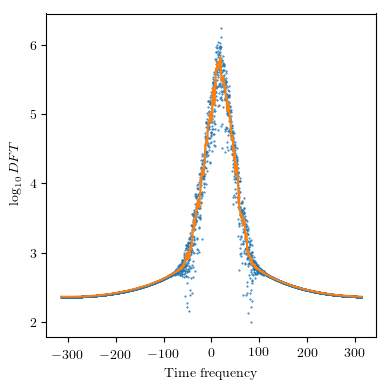

In [15]:
plt.figure(figsize=(4,4), dpi=100)

ind = 250
plt.plot(time_freq, np.log10(mag[:,250]), '.', markersize=1)
phi_freq[ind]

from scipy.optimize import curve_fit
from scipy.signal import find_peaks, find_peaks_cwt, medfilt

def gauss(x, a, mu, sigma):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

xdata = time_freq
ydata = np.log10(mag[:,250])
min_y = np.min(ydata)

popt, pcov = curve_fit(gauss, xdata, ydata-min_y, p0=[1, 40, 20])

maxinds = np.where(np.log10(mag[:,ind]) > np.max(np.log10(mag[:,ind]))-0.5)
ymean = np.mean(np.log10(mag[maxinds,ind]))
xmean = np.mean(time_freq[maxinds])

#plt.plot(xdata, gauss(xdata, popt[0], popt[1], popt[2]) + min_y)
#plt.plot(xmean, ymean, 'r*')

filtered = medfilt(ydata, 21)
plt.plot(xdata, filtered)
plt.xlabel('Time frequency')
plt.ylabel(r'$\log_{10} DFT$')

plt.tight_layout()

plt.savefig('../plots/filtering.pdf')

### Find the slope of the ridges at all angles

In [16]:
th_inds = np.arange(20,230, 5, dtype=int)
slope = np.zeros_like(th_inds, dtype=float)
error_slope = np.zeros_like(th_inds, dtype=float)
time_inds = np.arange(1000, 5000, 1)

for i in range(len(th_inds)):
    if i%10==0: print(i)

    sig_eq = om[:, :, th_inds[i]]
    sig_fft = np.fft.fft2(sig_eq[time_inds, :])
    sig_fft = np.fft.fftshift(sig_fft)
    dphi = phi[2] - phi[1]
    dt = t_arr[2] - t_arr[1]
    phi_freq = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(phi), d=dphi))
    time_freq = -2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(t_arr[time_inds]), d=dt))
    
    mag = np.abs(sig_fft)
    ridge = np.zeros(phi_freq.shape[0])
    ridge2 = np.zeros(phi_freq.shape[0])

    for j, m in enumerate(phi_freq):
        if np.abs(m)<m_max:
            #### method 1
            #maxinds = np.where(np.log10(mag[:,j]) > np.max(np.log10(mag[:,j]))-0.5)
            #xmean = np.mean(time_freq[maxinds])
            #ridge[j] = xmean
            
            #### method 2
            #delta_inds = 50
            #max_ind = np.argmax(mag[:,j])
            #ridge[j] = np.mean(time_freq[max_ind-delta_inds:max_ind+delta_inds])
            
            #### method 3 - median filter
            filtered = medfilt(np.log10(mag[:,j]), 21)
            max_ind = np.argmax(filtered)
            ridge[j] = time_freq[max_ind]
            
            filtered2 = medfilt(np.log10(mag[:,j]), 1)
            max_ind2 = np.argmax(filtered2)
            ridge2[j] = time_freq[max_ind2]
        
        else:
            ridge[j] = np.nan
            ridge2[j] = np.nan

    idx = np.isfinite(ridge)
    p = np.polyfit(phi_freq[idx], ridge[idx], 1)
    
    idx2 = np.isfinite(ridge2)
    p2 = np.polyfit(phi_freq[idx2], ridge2[idx2], 1)
    
    slope[i] = p[0]
    error_slope[i] = np.abs(p[0]-p2[0])
    


0
10
20
30
40


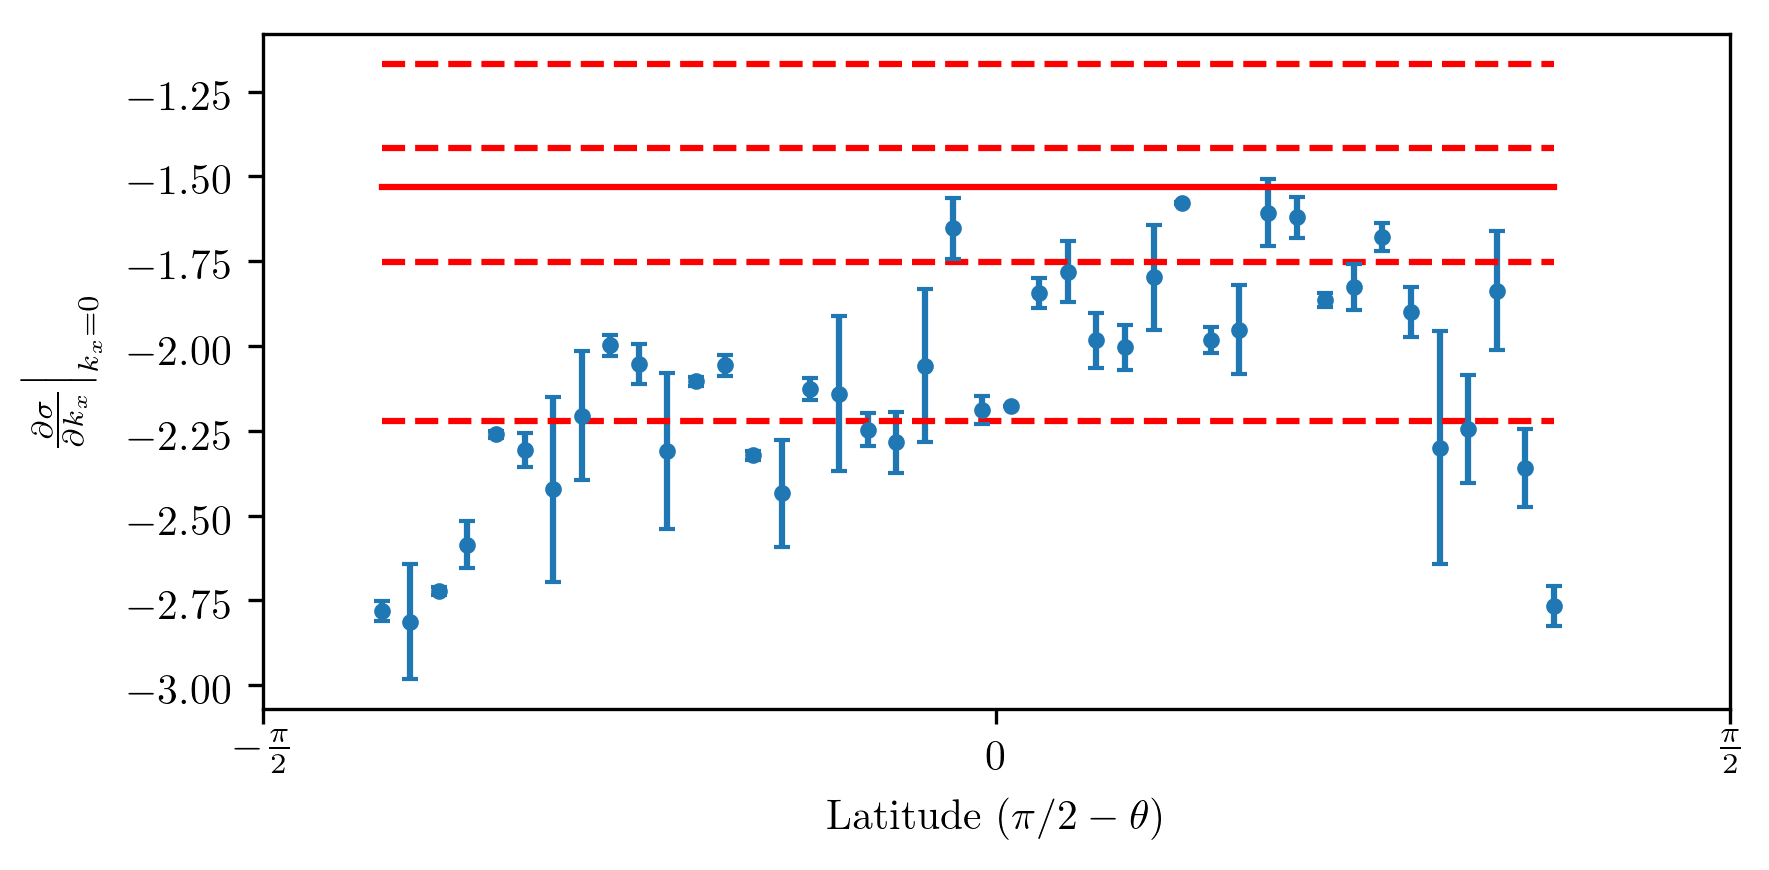

In [22]:
plt.figure(figsize=(6,3), dpi=300)

#set the vertical wavenumber
k_m, k_p = get_k(*get_gammas(Lmid,1))
k_max = get_kmax(*get_gammas(Lmid,1))

c00 = (-2*Omega/(k_max**2))*np.ones_like(theta[th_inds])
plt.plot(np.pi/2-theta[th_inds], c00, 'r-')

for kx in np.linspace(k_m, k_p, 4):
    c0 = (-2*Omega/(kx**2))*np.ones_like(theta[th_inds])
    plt.plot(np.pi/2-theta[th_inds], c0, 'r--')
    
    
#plt.plot(theta[th_inds], slope*np.sin(theta[th_inds]), '*', markersize=2)  
plt.errorbar(np.pi/2-theta[th_inds], slope*np.ones_like(theta[th_inds]), yerr=error_slope*np.ones_like(theta[th_inds]), fmt='o', \
            markersize=3, capsize=2)

plt.ylabel(r'$\left. \frac{\partial \sigma}{\partial k_x}  \right|_{k_x=0}$', usetex=True)
plt.xlabel(r'Latitude $(\pi/2-\theta)$', usetex=True)
plt.xticks([-np.pi/2, 0, np.pi/2], labels=[r"$-\frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$"])
plt.tight_layout()

plt.savefig('../plots/%s_slope_mod.pdf' %(STRNAME))

##### Below, we find the 2D FFT of the data for $\zeta$ for $0<\phi<2 \pi$ and over a $\theta$ interval

Time is 25.001000


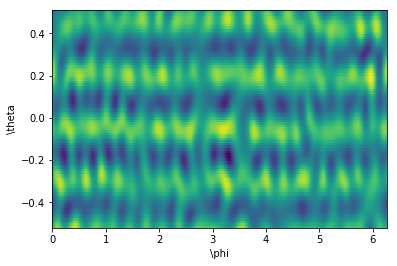

In [95]:
theta_window = 60  #total window size over which to do fft
lat = (np.pi/2 - theta) * 180 / np.pi
th = np.pi/2 - theta #latitude in radians 
#get inds 
ind1 = (np.abs(lat + theta_window/2)).argmin()
ind2 = (np.abs(lat - theta_window/2)).argmin()
th_inds = np.arange(ind1, ind2, 1, dtype=int)

t_ind = 2500
print('Time is %f' %(t_arr[t_ind]))

plt.pcolor(phi, th[th_inds], om[t_ind, :, th_inds])
plt.xlabel(r'\phi'); plt.ylabel(r'\theta');

#find FFT 
om_fft2 = np.fft.fftshift(np.fft.fft2(om[t_ind, :, th_inds]))
om_fft_log = np.log10(np.abs(om_fft2))
om_fft_abs = np.abs(om_fft2)

#find frequencies 
dphi = phi[2] - phi[1]
dth = th[2] - th[1]
th_freq = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(th[th_inds]), d=dth))
phi_freq = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(phi), d=dphi))


/Users/Rohit/anaconda3/envs/mayavi/lib/python3.6/site-packages/matplotlib/collections.py:874: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


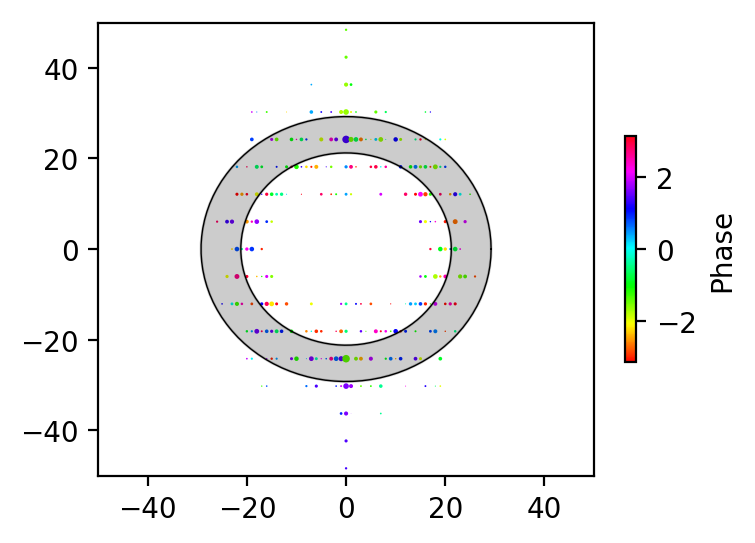

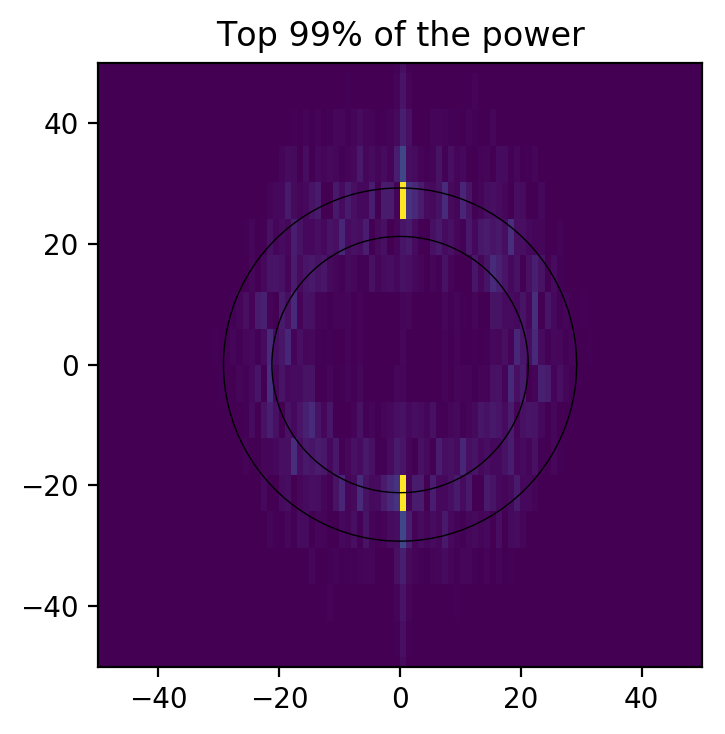

In [96]:
phase = np.angle(om_fft2)
mag = np.abs(om_fft2)
kxkx, kyky = np.meshgrid(phi_freq, th_freq)

#plot the most unstable mode
gammas = get_gammas(Lmid, 1)
k_max = get_kmax(*gammas)
k_m, k_p = get_k(*gammas)

##
fig = plt.figure(figsize=(4,3), dpi=200)
img = plt.scatter(kxkx.flatten(), kyky.flatten(), 5*(np.log10(mag.flatten())-4.5), \
            c=phase.flatten(), edgecolor='none', cmap = 'hsv')
plt.ylim([-50, 50])
plt.xlim([-50, 50])
clb = fig.colorbar(img, shrink=0.5)
clb.set_label('Phase')
th_temp = np.linspace(0,2*np.pi, 100)

plt.plot(k_m*np.cos(th_temp), k_m*np.sin(th_temp), 'k', linewidth=0.5)
plt.plot(k_p*np.cos(th_temp), k_p*np.sin(th_temp), 'k', linewidth=0.5)

ring = Wedge((0, 0), k_p, 0, 360, width=k_p-k_m, color='k', alpha=0.2)
plt.gca().add_patch(ring)

#plot the FFT amplitude
plt.figure(figsize=(8,4), dpi=200)
plt.pcolormesh(phi_freq, th_freq, om_fft_abs)
#plt.colorbar(); 
plt.clim([0.01*np.max(om_fft_abs), np.max(om_fft_abs)])
plt.axis('scaled')
plt.ylim([-50, 50]); plt.xlim([-50, 50])
plt.title('Top 99% of the power')

#plt.plot(k_p*np.cos(th_temp), k_max*np.sin(th_temp), 'k', linewidth=0.5)
plt.plot(k_m*np.cos(th_temp), k_m*np.sin(th_temp), 'k', linewidth=0.5)
plt.plot(k_p*np.cos(th_temp), k_p*np.sin(th_temp), 'k', linewidth=0.5)

In [ ]:
plt.plot(np.sort(np.log10(mag.flatten())))

### Make video

The FFT plot must be sensitive to the time point that is chosen. Let us see how the modes in the Fourier space evolve around the equator. This can also serve as a good test for the beta-plane approximation. 

/Users/Rohit/anaconda3/envs/mayavi/lib/python3.6/site-packages/matplotlib/collections.py:874: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Frame: 100
Frame: 400
Frame: 700
Frame: 1000


/Users/Rohit/anaconda3/envs/mayavi/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10
/Users/Rohit/anaconda3/envs/mayavi/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in log10


Frame: 1300
Frame: 1600
Frame: 1900
Frame: 2200
Frame: 2500
Frame: 2800


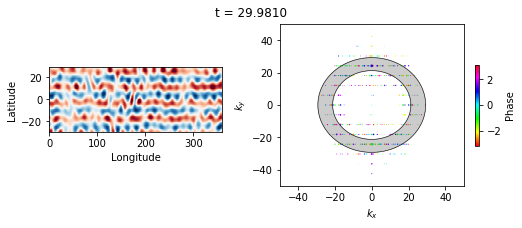

In [97]:
plt.rc('text', usetex=False)

fig = plt.figure(figsize=(8,3))

dpi = 300
FPS = 15
metadata = dict(title='Movie', artist='Matplotlib', comment='Movie support!')
writer = FFMpegWriter(fps=FPS, metadata=metadata)
edgecolor = 'k'
axes1 = plt.axes((0.15, 0.4, 0.3, 0.3))
axes2 = plt.axes((0.55, 0.15, 0.4, 0.75))

first_frame = 1
last_frame = 3000

#plot the most unstable mode
γ0, γ2, γ4 = get_gammas(Lmid, 1)
k_max = np.sqrt(-γ2/(2*γ4))
k_m = np.sqrt((-γ2 - np.sqrt(γ2**2 - 4*γ0*γ4))/(2*γ4))
k_p = np.sqrt((-γ2 + np.sqrt(γ2**2 - 4*γ0*γ4))/(2*γ4))
    
kxkx, kyky = np.meshgrid(phi_freq, th_freq)
mag_fac = 1e-5
step = 3
with writer.saving(fig, "../videos/%s_beta_plane_log.mp4" %(STRNAME), dpi):
    
    for i in range(first_frame, last_frame + 1, step):
        if i%100==0: print('Frame: %i' %(i))
        
        #find FFT 
        om_fft2 = np.fft.fftshift(np.fft.fft2(om[i, :, th_inds]))
        om_fft_log = np.log10(np.abs(om_fft2))
        mag = np.abs(om_fft2)
        phase = np.angle(om_fft2)
        time = t_arr[i]

        # Create plots
        if i == first_frame:
            
            #first plot
            image1 = axes1.pcolormesh(phi*180/np.pi, th[th_inds]*180/np.pi, om[i, :, th_inds], \
                                      vmax=0.6*om_max, vmin=-0.6*om_max, cmap='RdBu_r')
            axes1.set_xlabel(r'Longitude'); axes1.set_ylabel(r'Latitude');
            
            #second plot
            image2 = axes2.scatter(kxkx.flatten(), kyky.flatten(), 5*(np.log10(mag.flatten())-4.5), \
            c=phase.flatten(), edgecolor='none', cmap = 'hsv')
            axes2.set_ylim([-50, 50])
            axes2.set_xlim([-50, 50])
            clb = fig.colorbar(image2, shrink=0.5)
            clb.set_label('Phase')
            axes2.plot(k_m*np.cos(th_temp), k_m*np.sin(th_temp), 'k', linewidth=0.5)
            axes2.plot(k_p*np.cos(th_temp), k_p*np.sin(th_temp), 'k', linewidth=0.5)
            axes2.set_xlabel(r'$k_x$');
            axes2.set_ylabel(r'$k_y$')
            ring = Wedge((0, 0), k_p, 0, 360, width=k_p-k_m, color='k', alpha=0.2)
            axes2.add_patch(ring)
            
            title = fig.suptitle('t = %.4f' %time)
            #plt.tight_layout()

            
            #image2 = plt.pcolor(phi_freq, th_freq, om_fft_abs)
            #plt.colorbar(); 
            #plt.clim([0.01*np.max(om_fft_abs), np.max(om_fft_abs)])
            #plt.axis('scaled')
            #plt.ylim([-50, 50]); plt.xlim([-50, 50])
            
            #plt.plot(k_m*np.cos(th_temp), k_m*np.sin(th_temp), 'k', linewidth=0.5)
            #plt.plot(k_p*np.cos(th_temp), k_p*np.sin(th_temp), 'k', linewidth=0.5)

        # Update plot
        else:
            image1.set_array(om[i, :, th_inds][:-1,:-1].ravel())
            image2.set_sizes(5*(np.log10(mag.flatten())-4.5))
            image2.set_array(phase.flatten())
            
            title.set_text('t = %.4f' %time)
                
        
        writer.grab_frame()

In [ ]:
theta_window = 60 #total window size over which to do fft
lat = (np.pi/2 - theta) * 180 / np.pi
th = np.pi/2 - theta #latitude in radians 
#get inds 
ind1 = (np.abs(lat + theta_window/2)).argmin()
ind2 = (np.abs(lat - theta_window/2)).argmin()
t_inds = np.arange(4500, t_arr.shape[0], 1, dtype=int)

#### Plot the analytical dispersion relation 

$$
\sigma = \frac{-\beta k_x}{k_x^2 + k_y^2}
$$

In [ ]:
k0_ = 12
kx_, ky_ = np.meshgrid(np.linspace(-20, 20, 100), np.linspace(-20, 20, 100))
sig_ = -2*Omega*kx_/k0_**2

from mayavi import mlab
from mayavi.mlab import *
mlab.init_notebook()

surf(kx_, ky_, sig_)



In [ ]:
plt.pcolor(kx_, ky_, sig_)

In [ ]:
#find FFT 
om_fft = np.fft.fftshift(np.fft.fftn(om[t_inds, :, ind1:ind2]))

In [ ]:
dphi = phi[2] - phi[1]
dt = t_arr[2] - t_arr[1]
dth = th[2] - th[1]
th_freq = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(th[ind1:ind2]), d=dth))
phi_freq = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(phi), d=dphi))
time_freq = -2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(t_arr[t_inds]), d=dt))

In [ ]:
plt.pcolor(phi_freq, th_freq, np.log10(np.abs(om_fft[400, :, :])).T)
plt.xlim([-100, 100])

plt.figure()
plt.subplot(121)
plt.plot(phi_freq, np.log10(np.abs(om_fft[400, :, 40])))
plt.subplot(122)
plt.plot(th_freq, np.log10(np.abs(om_fft[400, 256, :])))

In [ ]:
phi_freq.shape

In [ ]:
from mayavi import mlab
from mayavi.mlab import *
mlab.init_notebook()
sig, kx, ky = np.meshgrid(time_freq, phi_freq, th_freq, indexing='ij')

contour3d(sig, kx, ky, np.log10(np.abs(om_fft)), contours=4,  transparent=True)


In [ ]:
om_fft.shape

In [ ]:
import numpy
from mayavi.mlab import *

def test_contour3d():
    x, y, z = np.ogrid[-5:5:64j, -5:5:64j, -5:5:64j]

    scalars = x * x * 0.5 + y * y + z * z * 2.0

    obj = contour3d(scalars, contours=4, transparent=True)
    return obj

In [ ]:
test_contour3d()

In [9]:
np.arctan(8)*180/np.pi

82.87498365109819

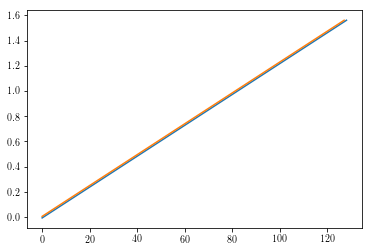

In [71]:
plt.plot(np.pi/2 - theta[127:])
plt.plot(theta[127::-1]-np.pi/2)

In [8]:
get_l(2,1)

(5.209068706723535, 7.209068706723536)

In [9]:
get_l(4,1)

(10.412398732682817, 14.41239873268282)

In [10]:
get_l(8,1)

(20.818716849367334, 28.81871684936733)